## Predicting Churn for Credit Card Customers using Data Mining Methods
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
### Team # 5 Members:
Martin Zagari<br>
Roberto Cancel<br>
Filipp Krasovsky<br>
<br>
GitHub Repository link: https://github.com/rcancel3/ADS505 <br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>


<p style="border:3px; border-style:solid; border-color:black; padding: 1em;">
    <b>Problem Statement</b><br>
A manager at the bank is disturbed by more and more customers leaving their credit card <br>
services. They have contacted the data science team to see if there’s viability to predict <br>
which customers are going to churn – the insights generated by this process would allow <br>
the company to proactively reach out through customer service channels and utilize <br>
available retention efforts.
</p>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


In [151]:
import numpy as np
from numpy import exp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,  GridSearchCV

# For Logistic Regression modeling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from dmba import classificationSummary, gainsChart, liftChart
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# For Neural Network modeling
from sklearn.neural_network import MLPClassifier
from dmba import classificationSummary
from sklearn.metrics import classification_report

# For ensemble modeling - Voting for Classification
from sklearn.ensemble import VotingClassifier

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
Import the data set<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

In [86]:
#import dataset
url = 'https://raw.githubusercontent.com/rcancel3/ADS505/main/BankChurners.csv'
df = pd.read_csv(url, index_col= None, header= 0)

#drop and transform traits:
df = df.drop("CLIENTNUM",axis=1)

def transform_flag(f):
    if(f=="Existing Customer"):
        return 0
    return 1

df.Attrition_Flag = df.apply(lambda row: transform_flag(row.Attrition_Flag),axis=1 )
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [87]:
#70-10-20 train/validation/test
test_size= int(round(len(df)*.20,0))
train, validation = train_test_split(df, test_size=0.30, random_state = 0)
validation,test   = train_test_split(validation,test_size=test_size,random_state=0)

train_index = train.index
validation_index=validation.index
test_index=test.index 

#take a partition and spit out an array of the predictors and target.
#intended use part_X,part_y = extract_xy(split)
def extract_xy(split):
    X = split.drop("Attrition_Flag",axis=1)
    y = split.Attrition_Flag
    return([X,y])

#get all six partitions from any df you want.
#intended use: train_X,train_y,val_X,val_y,test_X,test_y = partition_fully(bc_clean)
def partition_fully(some_df):
    #use our global partitions to take in a dataframe and turn into 3 parts
    train_df = some_df.loc[train_index]
    test_df  = some_df.loc[test_index]
    val_df   = some_df.loc[validation_index]
    
    #we don't know what vars we use to train, but we know that y is always attrition_flag,
    #and we know that x is always !y
    train_X,train_y = extract_xy(train_df)
    test_X,test_y = extract_xy(test_df)
    val_X,val_y = extract_xy(val_df)
    
    return([train_X,train_y,val_X,val_y,test_X,test_y])

In [88]:
train.index

Int64Index([4813, 9887, 4191, 7527, 5081,  783, 7538, 6535, 4924, 1737,
            ...
            3468, 6744, 5874, 4373, 7891, 9225, 4859, 3264, 9845, 2732],
           dtype='int64', length=7088)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Describe Characteristics (Feature types, missing values, etc)  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

In [89]:
# dataframe.size
size = df.size
# dataframe.shape
shape = df.shape
# dataframe.ndim
ndim = df.ndim
# printing size and shape
print("Size = {}\nShape ={}\nShape[0] x Shape[1] = {}".
format(size, shape, shape[0]*shape[1]))

Size = 202540
Shape =(10127, 20)
Shape[0] x Shape[1] = 202540


In [90]:
#alias for the rest of the notebook.
bc = df
# Determine extent of missing data - only print columns with null values.
null_vals = bc.isnull().sum()
print(null_vals[null_vals>0])

Series([], dtype: int64)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Note no missing values; however, further exploration indicates "Unknown" values exist  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

In [91]:
# Describe feature types (object = categorical variables to converted to numeric)
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
Summary of Features, Explorations, Transformations<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


1-CLIENTNUM int64<br>
Client number. Unique identifier for the customer holding the account<br>
DELETED<br>
Adds no value to the index number

2-Attrition_Flag object<br>
Internal event (customer activity) variable - if the account is closed then 1 else 0<br>
Action: Convert to binary

3-Customer_Age int64<br>
Demographic variable - Customer's Age in Years<br>
Action: Bin Age, scale, or rationalize

4-Gender object<br>
Demographic variable - M=Male, F=Female<br>
Action: Convert to binary 

5-Dependent_count int64<br>
Demographic variable - Number of dependents<br>
Action: Explore relationship to determine viability

6-Education_Level object<br>
Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)<br>
Action: Dummy Encode or ordinal.

7-Marital_Status object<br>
Demographic variable - Married, Single, Divorced, Unknown<br>
Action: Convert to binary: isMarried - Married = 1 | All others = 0

8-Income_Category object<br>
Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, ><br>
Action: Dummy Encode or ordinal.

9-Card_Category object<br>
Product Variable - Type of Card (Blue, Silver, Gold, Platinum)<br>
Action: Convert to is.blue (blue=1, Silver, Gold, Platinum = 0)

10-Months_on_book int64<br>
Period of relationship with bank<br>

11-Total_Relationship_Count int64<br>
Total no. of products held by the customer<br>

12-Months_Inactive_12_mon int64<br>
No. of months inactive in the last 12 months<br>

13-Contacts_Count_12_mon int64<br>
No. of Contacts in the last 12 months<br>

14-Credit_Limit float64<br>
Credit Limit on the Credit Card<br>

15-Total_Revolving_Bal int64<br>
Total Revolving Balance on the Credit Card<br>

16-Avg_Open_To_Buy float64<br>
Open to Buy Credit Line (Average of last 12 months)<br>

17-Total_Amt_Chng_Q4_Q1 float64<br>
Change in Transaction Amount (Q4 over Q1<br>

18-Total_Trans_Amt int64<br>
Total Transaction Amount (Last 12 months)<br>

19-Total_Trans_Ct int64<br>
Total Transaction Count (Last 12 months)<br>

20-Total_Ct_Chng_Q4_Q1 float64<br>
Change in Transaction Count (Q4 over Q1) <br>

21-Avg_Utilization_Ratio float64<br>
Average Card Utilization Ratio<br>


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Feature Exploration -  Numeric  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

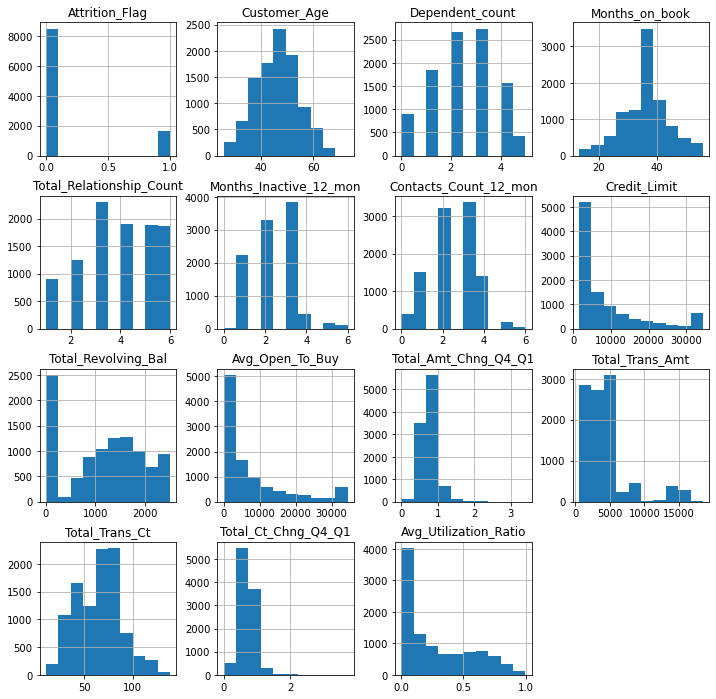

In [92]:
#Examine distributions of numeric features
histlist = bc.hist(figsize = (12,12))

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
Summary of Numeric Feature Distributions<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
  
Avg_Open_To_Buy, Avg_Utilization_Rate, & Credit_limit have similar right-skewed distributions.
  
Customer_Age and Months_on_book are similarly normally distributed.
  
Contacts_Count_12_mon and Months_inactive_12_mon have similar distributions.
  
Total_Amt_Chng_Q4_Q1 and Total_Ct_Chng_Q4_Q1 have similar distributions.

Further Evaluation of numeric features is conducted using Correlation Heat Map.  

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Feature Exploration -  Categorical    
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

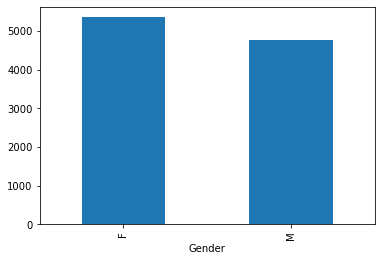

In [97]:
# Distribution of Gender
bc.groupby('Gender').size().plot.bar()
plt.show()

In [99]:
# Explore Gender Relationship with Attrition_Flag
t1 = pd.crosstab(bc['Gender'], bc['Attrition_Flag'])
t1['Total'] = t1.sum(axis=1)
t1.loc['Total'] = t1.sum()
t1['Attrition_Percent'] = ((t1.iloc[:,1])/((t1.iloc[:,0])+(t1.iloc[:,1])))
print(t1)

Attrition_Flag     0     1  Total  Attrition_Percent
Gender                                              
F               4428   930   5358           0.173572
M               4072   697   4769           0.146152
Total           8500  1627  10127           0.160660


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Summary: Women have a higher attrition rate.  
Action: Transform to Binary Variable.  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

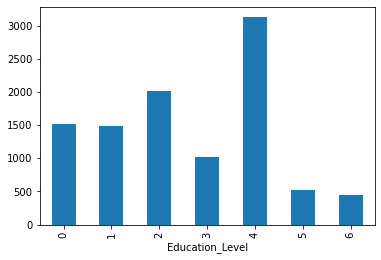

In [100]:
# Distribution of Education Level
bc.groupby('Education_Level').size().plot.bar()
plt.show()

In [101]:
# Maybe we can turn an education into an ordinal variable 
edu_ordinal = {
    "Unknown": 0,
    "Uneducated": 1,
    "High School": 2,
    "College": 3,
    "Graduate": 4,
    "Post-Graduate":5,
    "Doctorate":6
}

def ordinalize(edu):
    return edu_ordinal[edu]
bc.Education_Level = bc.apply(lambda row: ordinalize(row.Education_Level),axis=1)
bc.groupby('Education_Level').size().plot.bar()
plt.show()

KeyError: 2

In [102]:
# Explore Education_Level Relationship with Attrition_Flag
t2 = pd.crosstab(bc['Education_Level'], bc['Attrition_Flag'])
t2['Total'] = t2.sum(axis=1)
t2.loc['Total'] = t2.sum()
t2['Attrition_Percent'] = ((t2.iloc[:,1])/((t2.iloc[:,0])+(t2.iloc[:,1])))
print(t2)

Attrition_Flag      0     1  Total  Attrition_Percent
Education_Level                                      
0                1263   256   1519           0.168532
1                1250   237   1487           0.159381
2                1707   306   2013           0.152012
3                 859   154   1013           0.152024
4                2641   487   3128           0.155691
5                 424    92    516           0.178295
6                 356    95    451           0.210643
Total            8500  1627  10127           0.160660


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Summary: Clients with Doctorates have the highest attrition rate at ~21%.   
We also note that Clients w/Post_Graduate & Unknown education have higher attrition rates.    
High School Graduates and College educated clients have the lowest attrition rate.  
Uneducated clients have near the average attrition at ~16%.
  
Action: Education Level converted to ordinal variable. <br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

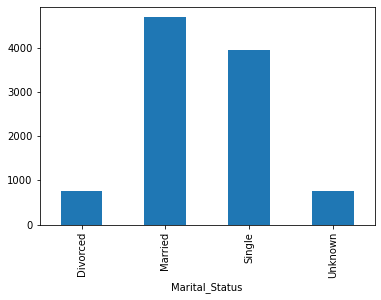

In [103]:
# Explore Marital Status Distribution
bc.groupby('Marital_Status').size().plot.bar()
plt.show()

In [105]:
# Explore Marital_Status Relationship with Attrition_Flag
t3 = pd.crosstab(bc['Marital_Status'], bc['Attrition_Flag'])
t3['Total'] = t3.sum(axis=1)
t3.loc['Total'] = t3.sum()
t3['Attrition_Percent'] = ((t3.iloc[:,1])/((t3.iloc[:,0])+(t3.iloc[:,1])))
print(t3)

Attrition_Flag     0     1  Total  Attrition_Percent
Marital_Status                                      
Divorced         627   121    748           0.161765
Married         3978   709   4687           0.151269
Single          3275   668   3943           0.169414
Unknown          620   129    749           0.172230
Total           8500  1627  10127           0.160660


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Summary: Married Clients have the lowest attrition.  
Unknown, Single, and Divorced have higher than mean attritition rates.  
Action: Create New binary Variable isMarried.  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

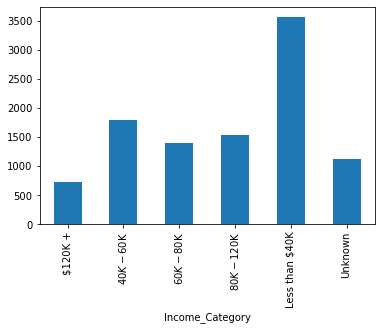

In [106]:
# Explore Income_Category Distribution
bc.groupby('Income_Category').size().plot.bar()
plt.show()

In [108]:
# Explore Income_Category Relationship with Attrition_Flag
t4 = pd.crosstab(bc['Income_Category'], bc['Attrition_Flag'])
t4['Total'] = t4.sum(axis=1)
t4.loc['Total'] = t4.sum()
t4['Attrition_Percent'] = ((t4.iloc[:,1])/((t4.iloc[:,0])+(t4.iloc[:,1])))
print(t4)

Attrition_Flag      0     1  Total  Attrition_Percent
Income_Category                                      
$120K +           601   126    727           0.173315
$40K - $60K      1519   271   1790           0.151397
$60K - $80K      1213   189   1402           0.134807
$80K - $120K     1293   242   1535           0.157655
Less than $40K   2949   612   3561           0.171862
Unknown           925   187   1112           0.168165
Total            8500  1627  10127           0.160660


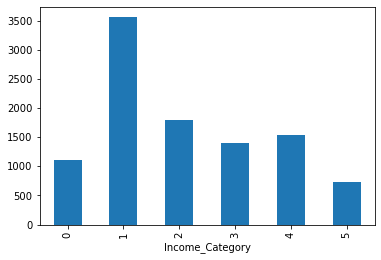

In [109]:
# Maybe we can turn an Income into an ordinal variable 
income_ordinal = {
    "Unknown": 0,
    "Less than $40K": 1,
    "$40K - $60K": 2,
    "$60K - $80K": 3,
    "$80K - $120K": 4,
    "$120K +":5
}

def inc_ordinalize(edu):
    return income_ordinal[edu]
bc.Income_Category = bc.apply(lambda row: inc_ordinalize(row.Income_Category),axis=1)
bc.groupby('Income_Category').size().plot.bar()
plt.show()

In [110]:
# Explore Income_Category Relationship with Attrition_Flag
t4 = pd.crosstab(bc['Income_Category'], bc['Attrition_Flag'])
t4['Total'] = t4.sum(axis=1)
t4.loc['Total'] = t4.sum()
t4['Attrition_Percent'] = ((t4.iloc[:,1])/((t4.iloc[:,0])+(t4.iloc[:,1])))
print(t4)

Attrition_Flag      0     1  Total  Attrition_Percent
Income_Category                                      
0                 925   187   1112           0.168165
1                2949   612   3561           0.171862
2                1519   271   1790           0.151397
3                1213   189   1402           0.134807
4                1293   242   1535           0.157655
5                 601   126    727           0.173315
Total            8500  1627  10127           0.160660


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Summary: 120k+ represent the highest attrition rate, followed by Less than 40k.  
60-80K clients have the lowest attrition rate, followed by 40-60k, then 80-120k.  
Unknown income has a higher than mean attrition rate. 
  
Action: Income_Category converted to ordinal variable to retain this information.  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

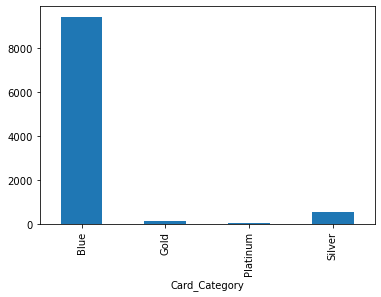

In [111]:
# Explore Card_Category Distribution
bc.groupby('Card_Category').size().plot.bar()
plt.show()

In [21]:
# Explore Card_Category Relationship with Attrition_Flag
t5 = pd.crosstab(bc['Card_Category'], bc['Attrition_Flag'])
t5['Total'] = t5.sum(axis=1)
t5.loc['Total'] = t5.sum()
t5['Attrition_Percent'] = ((t5.iloc[:,0])/((t5.iloc[:,0])+(t5.iloc[:,1])))
print(t5)

Attrition_Flag     0     1  Total  Attrition_Percent
Card_Category                                       
Blue            7917  1519   9436           0.839021
Gold              95    21    116           0.818966
Platinum          15     5     20           0.750000
Silver           473    82    555           0.852252
Total           8500  1627  10127           0.839340


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Summary: While there is a marked difference in the attrition rate based by card  
category, we see that 9436/10127 or 93% of clients are Blue Card holders.  

Action: Drop Card_Category.  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Feature Transformation -  Categorical    
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

In [112]:
# Tranform Gender and Marital_Status into Binary Features
bc.Gender.replace({'F': 1, 'M': 0}, inplace=True)
bc.Marital_Status.replace({'Married': 1,'Divorced': 0, 'Single': 0, 'Unknown': 0}, inplace=True)

# Rename Transformed Categorical Variables
bc.rename(columns={'Gender': 'isFemale', 'Marital_Status': 'isMarried'}, inplace = True)

#Convert to integers
bc['isFemale'] = bc['isFemale'].astype('int64')
bc['isMarried'] = bc['isMarried'].astype('int64')

bc.head()

,Attrition_Flag,Customer_Age,isFemale,Dependent_count,Education_Level,isMarried,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,0,3,2,1,3,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,1,5,4,0,1,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,0,3,4,1,4,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,1,4,2,0,1,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,0,3,1,1,3,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [60]:
# Drop Card_category
bc_trans = bc.drop(columns=['Card_Category'])

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Target Exploration and Transformation    
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

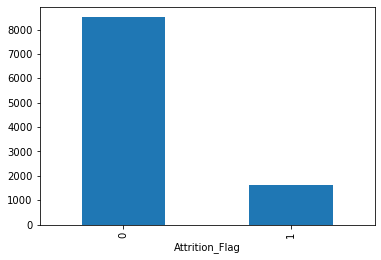

In [24]:
# Examine Attrition Rate
bc_trans.groupby('Attrition_Flag').size().plot.bar()
plt.show()

In [61]:
# Determine extent of churn
churn_count = len(bc_trans[bc_trans['Attrition_Flag']== 1])
no_churn_count = len(bc_trans[bc_trans['Attrition_Flag']==0])
pct_churn_count = churn_count / (churn_count + no_churn_count)
print('Percentage of Attrited Customers is: ', round(pct_churn_count*100,2),'%')
pct_no_churn_count = no_churn_count / (churn_count + no_churn_count)
print('Percentage of Existing Customers is: ', round(pct_no_churn_count*100,2),'%')

Percentage of Attrited Customers is:  16.07 %
Percentage of Existing Customers is:  83.93 %


We note an imbalanced data set with 16.07% churn (attrited customers)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Exploring Feature and Target Correlation to eliminate Multicollinearity   
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

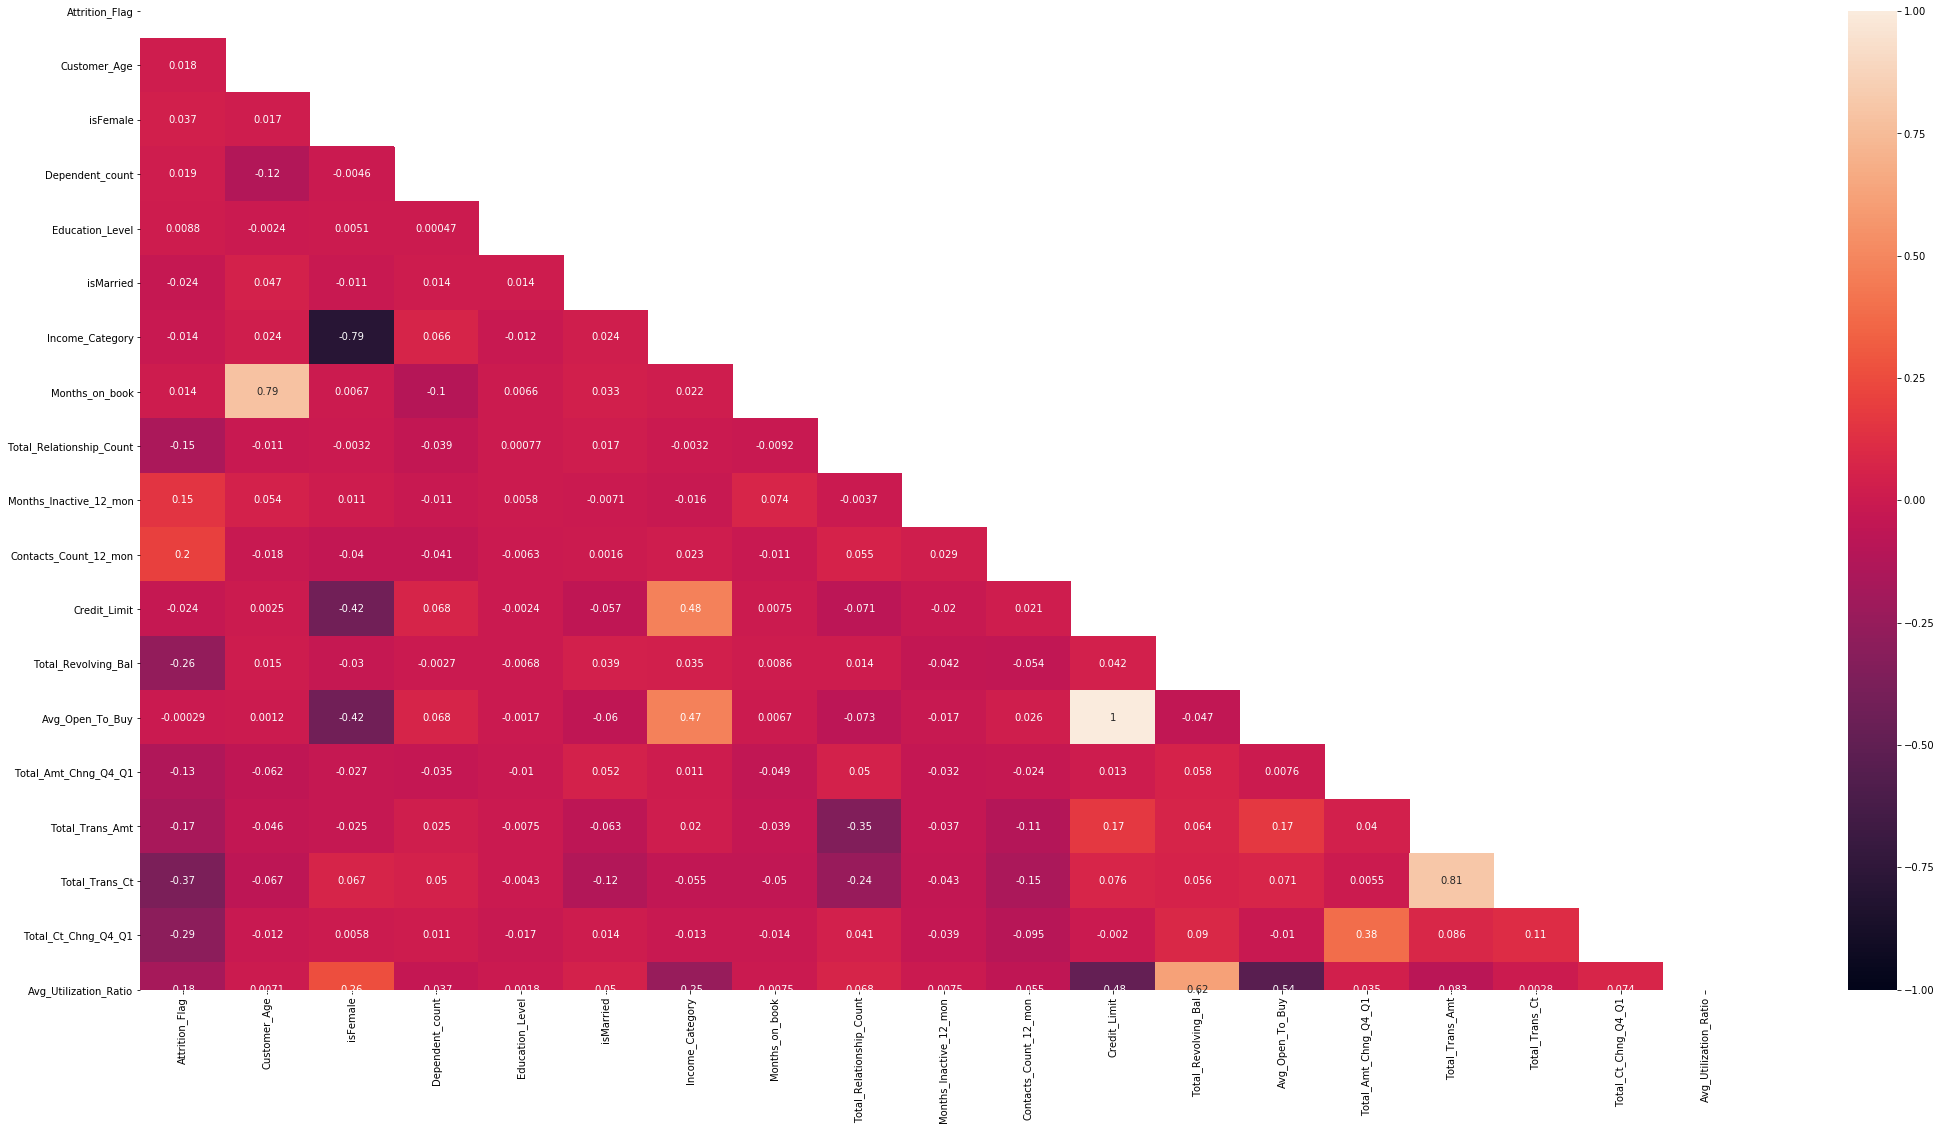

In [26]:
# Correlation Matrix for multicollinearity
plt.figure(figsize=(36, 18))
mask = np.triu(np.ones_like(bc_trans.corr(), dtype=np.bool))
heatmap = sns.heatmap(bc_trans.corr(), mask=mask, vmin=-1, vmax=1, annot=True)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Summary: 

Customer_Age and Months_on_book are highly correlated.    
Action: removing Age to retain banking-relationship    
  
Credit limit is perfectly correlated with Avg_open_to_buy  
Action: Drop Credit Limit  
  
Total_Trans_Cnt and Total_Trans_Amt are highly correlated.  
Action: Create New Feature Average Purchase = Total trans amount / Total Trans Count  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  


In [62]:
#Create new Average_Purchase feature
bc_trans['Avg_Purchase'] = (bc_trans['Total_Trans_Amt'])/(bc_trans['Total_Trans_Ct'])

# Drop Customer_Age and Credit Limit
bc_clean = bc_trans.drop(columns=['Customer_Age', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct'])

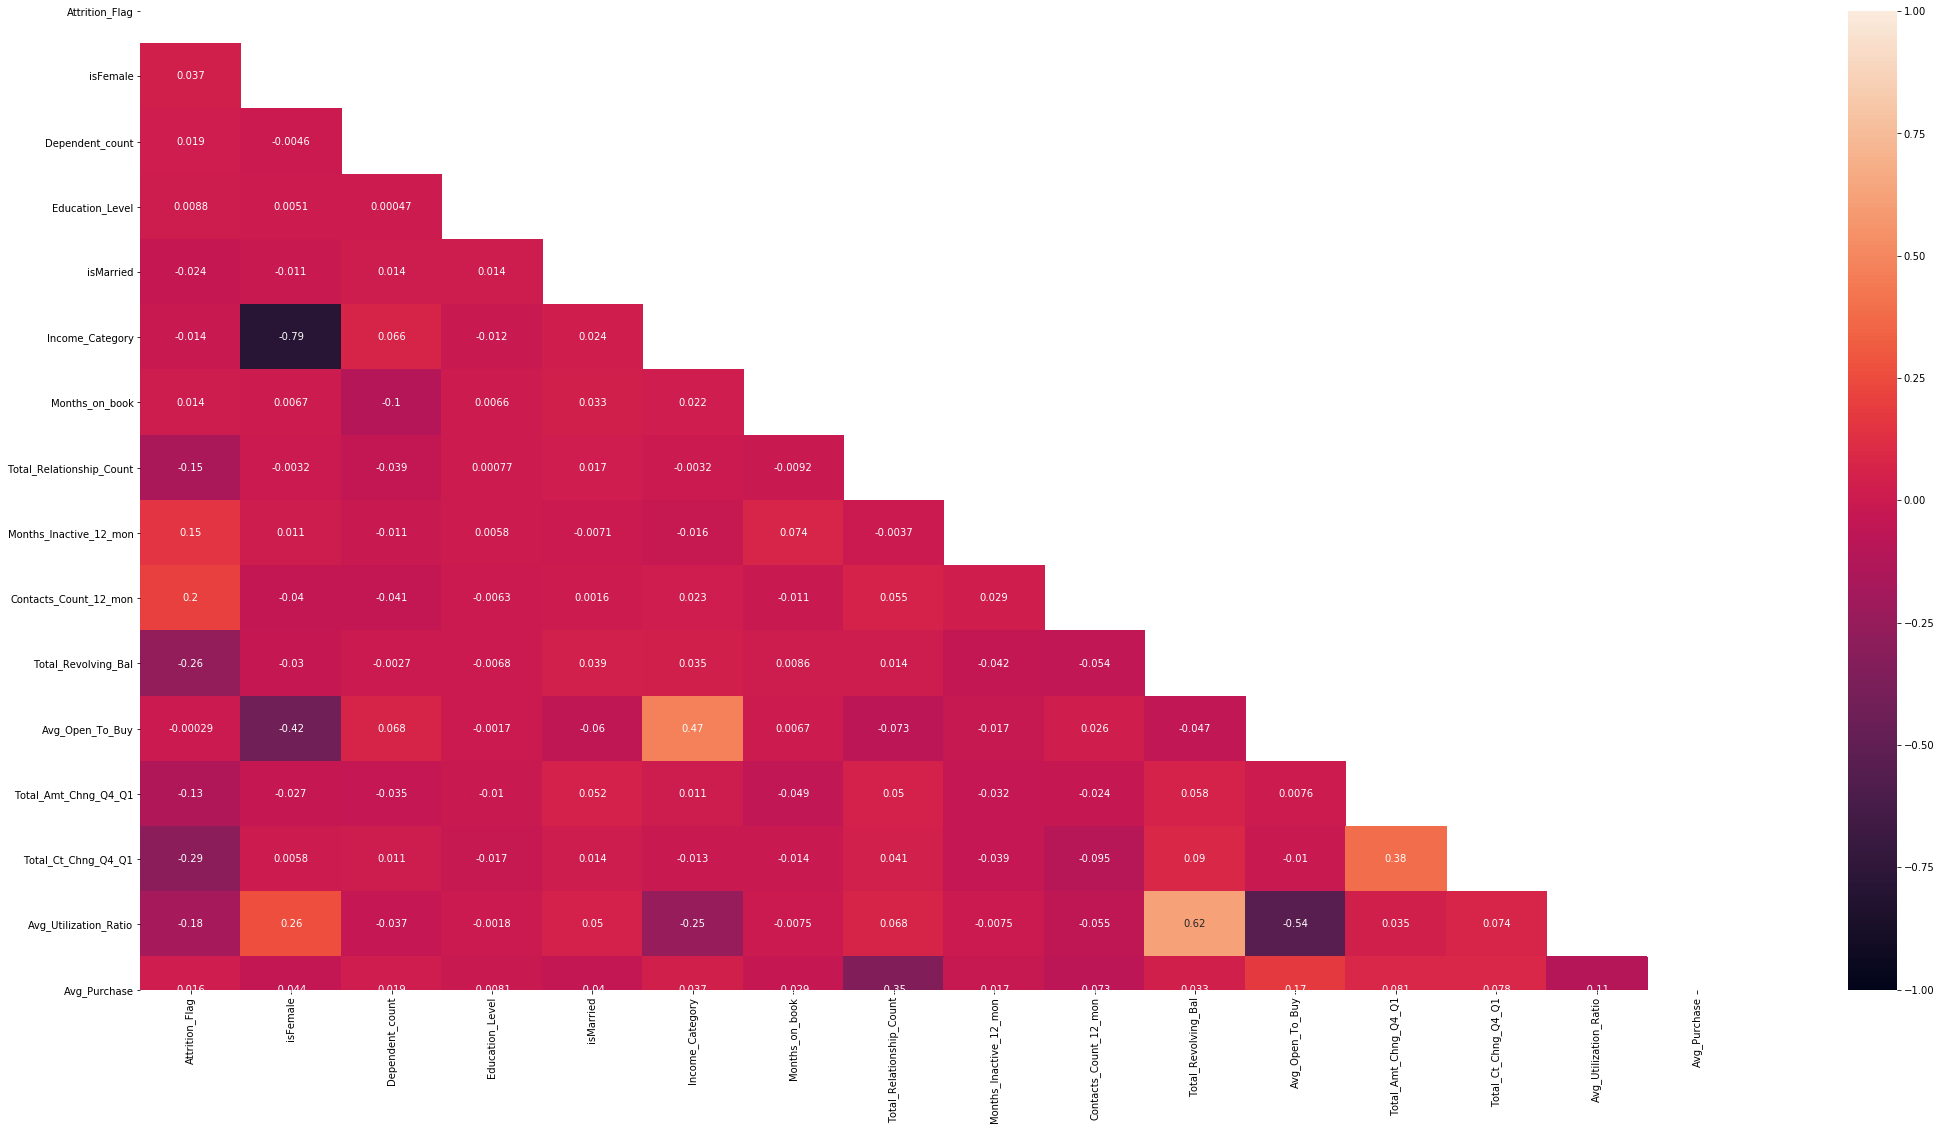

In [28]:
# Re-examine correlations
# Correlation Matrix for multicollinearity
plt.figure(figsize=(36, 18))
mask = np.triu(np.ones_like(bc_clean.corr(), dtype=np.bool))
heatmap = sns.heatmap(bc_clean.corr(), mask=mask, vmin=-1, vmax=1, annot=True)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Model Strategies:<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Logistic Regression: (Martin insert explanation)<br>
<br>
SVM w/gradient boosting: (Martin insert explanation)<br>
<br>
Random Forest: (Filipp insert explanation)<br>
<br>
Linear Discriminant Analysis: (Filipp insert explanation)<br>
<br>
Quadratic Discriminant Analysis: (Filipp insert explanation)<br>
<br>
Neural Network: (Roberto insert explanation)<br>
<br>
Ensemble - Voting Classifier: (Roberto insert explanation)<br>
<br> 

In [149]:
# Helper functions
def confusionMatrices(model, title):
    print(title + ' - Training results')
    classificationSummary(train_y, model.predict(train_x))
    print(title + ' - Validation results')
    y_pred = model.predict(val_x)
    print(title + ' Classification Summary')
    classificationSummary(val_y, y_pred)
    print(title + ' Classification Report')
    print(classification_report(val_y, y_pred))

In [194]:
#LDA
bc_lda = bc_clean.drop(
    ["Avg_Purchase","isFemale","Education_Level"],axis=1
)

train_x, train_y, val_x, val_y, test_x, test_y = partition_fully(bc_lda)
#LDA
solvers=["svd","lsqr","eigen"]
shrinkage = "auto"

for this_solver in solvers:
    lda = LinearDiscriminantAnalysis(solver=this_solver)
    lda.fit(train_x,train_y)
    this_f1 = f1_score(val_y,lda.predict(val_x))
    print(this_f1)
    
final_lda = LinearDiscriminantAnalysis().fit(train_x,train_y)
print(classification_report(test_y,final_lda.predict(test_x)))

0.44954128440366975
0.44954128440366975
0.44954128440366975
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1718
           1       0.69      0.37      0.48       307

    accuracy                           0.88      2025
   macro avg       0.79      0.67      0.71      2025
weighted avg       0.87      0.88      0.86      2025



Our LDA performs best with avgerage purchase, gender, and education taken out, with an F-score of roughly 45 percent on the validation set. For the final test set, we were able to secure an F-score of 93% for non-attrited customers, and 48% for the positive target.

In [196]:
#QDA
#Partition the dataset
bc_qda = bc_clean.drop(
        ["Avg_Purchase",
         "isFemale",
         "Avg_Open_To_Buy",
         "Total_Amt_Chng_Q4_Q1"],
        axis=1)

#scaler = MinMaxScaler()
#bc_qda = pd.DataFrame(scaler.fit_transform(bc_qda), index=df.index,columns=bc_qda.columns)
                     
train_x, train_y, val_x, val_y, test_x, test_y = partition_fully(bc_qda)

#train QDA over several reg params
scores=[]
reg_params = np.arange(0,1,0.1)
for i in reg_params:
    qda = QuadraticDiscriminantAnalysis(reg_param=i)
    qda.fit(train_x,train_y)
    this_f1 = (f1_score(val_y,qda.predict(val_x)))
    scores.append({i,this_f1})
    
print(max(scores))

qda = QuadraticDiscriminantAnalysis().fit(train_x,train_y)
print(classification_report(test_y,qda.predict(test_x)))

{0.0, 0.4876033057851239}
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1718
           1       0.72      0.45      0.56       307

    accuracy                           0.89      2025
   macro avg       0.81      0.71      0.75      2025
weighted avg       0.88      0.89      0.88      2025



In conclusion, our best performing QDA model has no regularization parameter and drops average purchase, gender, open to buy, and the total amount change between Q4 and Q1 from the predictor set. All of these variables were demonstrated to have caused a net increase in F1 score when dropped.<br>
<br> On the test set, we secured an F-score of 56% for the positive target, and an expectedly high f-score of 94% on the negative case (no attrition).

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Neural Network  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

In [31]:
# Alias the dataset for individual scaling to optimize models
bc_rob = bc_clean.copy()

# Min Max Scale the Data set for Neural Network
scaler = MinMaxScaler()
bc_NN = pd.DataFrame(scaler.fit_transform(bc_rob), index=df.index,
columns=bc_clean.columns)

#Partition the dataset
train_x, train_y, val_x, val_y, test_x, test_y = partition_fully(bc_NN)

In [37]:
# Train Neural Network with 1 hidden node
clf = MLPClassifier(hidden_layer_sizes=(1), activation='logistic', solver='lbfgs',
                    max_iter = 500, random_state=1)
clf.fit(train_x, train_y.values)
clf_confusion = confusionMatrices(clf, 'Neural network w/1 hidden layer')


Neural network w/1 hidden layer - Training results
Confusion Matrix (Accuracy 0.8845)

       Prediction
Actual    0    1
     0 5758  159
     1  660  511
Neural network w/1 hidden layer - Validation results
Neural network w/1 hidden layer Classification Summary
Confusion Matrix (Accuracy 0.8856)

       Prediction
Actual   0   1
     0 839  26
     1  90  59
Neural network w/1 hidden layer Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94       865
         1.0       0.69      0.40      0.50       149

    accuracy                           0.89      1014
   macro avg       0.80      0.68      0.72      1014
weighted avg       0.87      0.89      0.87      1014



In [42]:
param_grid = {
    'hidden_layer_sizes': list(range(2, 6)),
}
tuningNN = MLPClassifier(activation='logistic', solver='lbfgs', learning_rate = 'adaptive', random_state=1, max_iter=5000)
gridSearch = GridSearchCV(tuningNN, param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_x, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

tuningNN = gridSearch.best_estimator_
tuningNN_confusion = confusionMatrices(tuningNN, 'Tuned Neural network')

Improved score:  0.8992663656884876
Improved parameters:  {'hidden_layer_sizes': 5}
Tuned Neural network - Training results
Confusion Matrix (Accuracy 0.8981)

       Prediction
Actual    0    1
     0 5726  191
     1  531  640
Tuned Neural network - Validation results
Tuned Neural network Classification Summary
Confusion Matrix (Accuracy 0.8905)

       Prediction
Actual   0   1
     0 835  30
     1  81  68
Tuned Neural network Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       865
         1.0       0.69      0.46      0.55       149

    accuracy                           0.89      1014
   macro avg       0.80      0.71      0.74      1014
weighted avg       0.88      0.89      0.88      1014



In [ ]:
# Define best model to predict on test set
NeurNet = MLPClassifier(hidden_layer_sizes=(5), activation='logistic',learning_rate = 'adaptive',  solver='lbfgs',
                    max_iter = 5000, random_state=1)

In [ ]:
def modelGainsChart(model, title, ax=None):
    result = pd.DataFrame({
        'actual': y_test,
        'prob': model.predict_proba(X_test)[:, 1]
})

    result = result.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    ax = gainsChart(result.actual, ax=ax)
    ax.set_title(title)
    return ax

ax = modelGainsChart(neuralNet, 'Neural Network')

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Ensemble - Voting Classifier<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

In [ ]:
# create a dictionary of our models
estimators=[('Logistic Regression', ), ('SVM', ), ('randomForest', ), ('Linear Discriminant Analysis',), ('Neural Net', clf), ('Tuned Neural Net'),neuralNet ]
# create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard', weights=[])
# fit model to training data
ensemble.fit(X_train, y_train)
# Confusion Matrix of Ensemble model
ensemble_confusion = confusionMatrices(ensemble, 'Neural network')


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Results and Final Model Selection:<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

(performance measures, etc.)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Discussion and Conclusion:<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

(address the problem statement and suggestions that could go beyond the scope of the course.)